# Final Project: Detecting Risk of Heart Disease

##### Hayley Kisiel - hsk9ep
##### Avinaash Pavuloori - Akp8vy
##### Chelsea Alvarado - cxa6ky

### Initial Imports and Reading in File

In [1]:
from pyspark.sql import SparkSession
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
import seaborn as sns
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, DoubleType

In [2]:
infile = 'framingham.csv'

spark = SparkSession \
    .builder \
    .appName("fram CHD") \
    .getOrCreate()

df = spark.read.csv(infile, inferSchema=True, header = True)

# Data Exploration

### Preview Data

In [3]:
df.show(5)

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|   1| 39|        4|            0|         0|     0|              0|           0|       0|    195|106.0| 70.0|26.97|       80|     77|         0|
|   0| 46|        2|            0|         0|     0|              0|           0|       0|    250|121.0| 81.0|28.73|       95|     76|         0|
|   1| 48|        1|            1|        20|     0|              0|           0|       0|    245|127.5| 80.0|25.34|       75|     70|         0|
|   0| 61|        3|            1|        30|     0|              0|           1|       0|    225|150.0| 95.0|28.58|       6

### Check number of entries and column types

In [4]:
#count
count = df.count()
print("Number of observations: " + str(count))

#number of cols
col_num = len(df.columns)
print("Number of columns: " + str(col_num))
print("Number of features: " + str(col_num-1))

Number of observations: 4238
Number of columns: 16
Number of features: 15


In [5]:
#schema
print('Data overview')
df.printSchema()

Data overview
root
 |-- male: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- currentSmoker: integer (nullable = true)
 |-- cigsPerDay: string (nullable = true)
 |-- BPMeds: string (nullable = true)
 |-- prevalentStroke: integer (nullable = true)
 |-- prevalentHyp: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- totChol: string (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: string (nullable = true)
 |-- heartRate: string (nullable = true)
 |-- glucose: string (nullable = true)
 |-- TenYearCHD: integer (nullable = true)



### Evaluate Statistics

In [6]:
#overall variable statistics
print('Data frame describe:')
df.describe().toPandas()

Data frame describe:


,summary,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,count,4238,4238,4238,4238,4238,4238,4238,4238,4238,4238,4238,4238,4238,4238,4238,4238
1,mean,0.42921189240207647,49.58494572911751,1.9789499153157513,0.49410099103350635,9.003088619624615,0.02962962962962963,0.005899008966493629,0.31052383199622463,0.025719679093912224,236.72158548233045,132.35240679565834,82.89346389806512,25.80200758473571,75.87892376681614,81.96675324675324,0.1519584709768759
2,stddev,0.49502208553649146,8.572159925118484,1.0197906893122037,0.5000241969070374,11.920093587827756,0.16958356790200058,0.07658717064585814,0.46276269567370154,0.15831642786899564,44.590334318749456,22.038096643544563,11.910849600225525,4.080111062409031,12.026596351612579,23.959998189237467,0.3590229919902725
3,min,0,32,1,0,0,0,0,0,0,107,83.5,48.0,15.54,100,100,0
4,max,1,70,NA,1,NA,NA,1,1,1,NA,295.0,142.5,NA,NA,NA,1


In [7]:
for col in df.columns:
    df.describe([col]).show() 

+-------+-------------------+
|summary|               male|
+-------+-------------------+
|  count|               4238|
|   mean|0.42921189240207647|
| stddev|0.49502208553649146|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|             4238|
|   mean|49.58494572911751|
| stddev|8.572159925118484|
|    min|               32|
|    max|               70|
+-------+-----------------+

+-------+------------------+
|summary|         education|
+-------+------------------+
|  count|              4238|
|   mean|1.9789499153157513|
| stddev|1.0197906893122037|
|    min|                 1|
|    max|                NA|
+-------+------------------+

+-------+-------------------+
|summary|      currentSmoker|
+-------+-------------------+
|  count|               4238|
|   mean|0.49410099103350635|
| stddev| 0.5000241969070374|
|    min|                  0|
|   

### Feature Engineering

In [8]:
df = df.withColumn('PulsePressure', df.sysBP - df.diaBP)
df = df.select('male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose','PulsePressure', 'TenYearCHD')

### Missing Values

In [9]:
# replacing non-recorded values to null
df = df.na.replace({'NA': None})
df = df.na.replace({' ': None})

In [10]:
# compute number of missing values
df.agg(*[(F.count('*') - F.count(c)).alias(c)
for c in df.columns]).show()

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+---+---------+-------+-------------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|BMI|heartRate|glucose|PulsePressure|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+---+---------+-------+-------------+----------+
|   0|  0|      105|            0|        29|    53|              0|           0|       0|     50|    0|    0| 19|        1|    388|            0|         0|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+---+---------+-------+-------------+----------+



In [11]:
# explore cigsPerDay null data
df.filter(df.cigsPerDay.isNull()).show(1) # all of the null cigsPerDay are current smokers

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+----+---------+-------+-------------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP| BMI|heartRate|glucose|PulsePressure|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+----+---------+-------+-------------+----------+
|   1| 43|        4|            1|      null|     0|              0|           0|       0|    222|109.5| 69.0|25.5|       75|   null|         40.5|         0|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+----+---------+-------+-------------+----------+
only showing top 1 row



In [12]:
# change nulls 
df = df.fillna('2', subset=['education']) # set at average education
df = df.fillna('9', subset=['cigsPerDay']) # all null rows are current smokers so set at average cigsPerDay
df = df.fillna('0', subset=['BPMeds'])  # set to 0 since not recorded and mean close to 0
df = df.fillna('236', subset=['totChol']) # set at average totChol
df = df.fillna('25', subset=['BMI'])  # set at average totChol
df = df.fillna('75', subset=['heartRate']) # set at average heartRate
df = df.fillna('81', subset=['glucose']) # set at average glucose

In [13]:
#change column type back to int
df = df.withColumn("cigsPerDay", df["cigsPerDay"].cast(IntegerType()))
df = df.withColumn("BPMeds", df["BPMeds"].cast(IntegerType()))
df = df.withColumn("education", df["education"].cast(IntegerType()))
df = df.withColumn("totChol", df["totChol"].cast(IntegerType()))
df = df.withColumn("BMI", df["BMI"].cast(IntegerType()))
df = df.withColumn("heartRate", df["heartRate"].cast(IntegerType()))
df = df.withColumn("glucose", df["glucose"].cast(IntegerType()))
df = df.withColumn("TenYearCHD", df["TenYearCHD"].cast(DoubleType()))

### Check for Duplicates

In [14]:
# row count
print('total rows = {}'.format(df.count()))

# distinct row count
print('distint rows = {}'.format(df.distinct().count()))

total rows = 4238
distint rows = 4238


 #### Check for Counts

In [15]:
# how many of each out come
# how many 0
print('No CHD  = {}'.format(df.filter(df.TenYearCHD == 0).count())) # 0 = no CHD
print('Yes CHD  = {}'.format(df.filter(df.TenYearCHD == 1).count())) # 1 = yes CHD

No CHD  = 3594
Yes CHD  = 644


### Visualizations

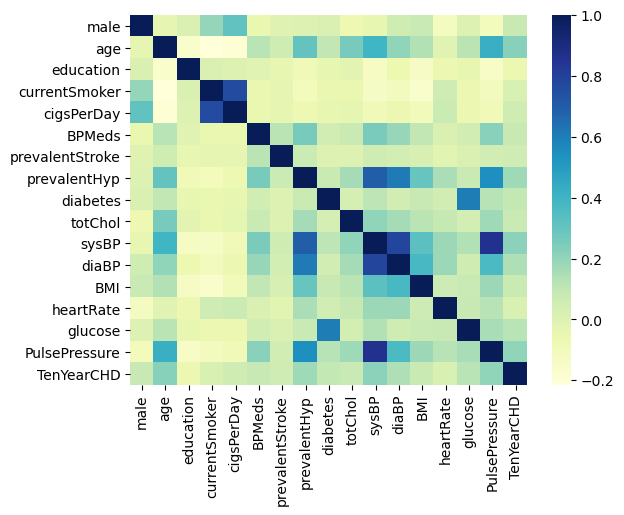

In [16]:
# coorelation plot
df_pd = df.toPandas() # using pandas for clear visualizations
heat = sns.heatmap(df_pd.corr(),cmap="YlGnBu")
plt.show()

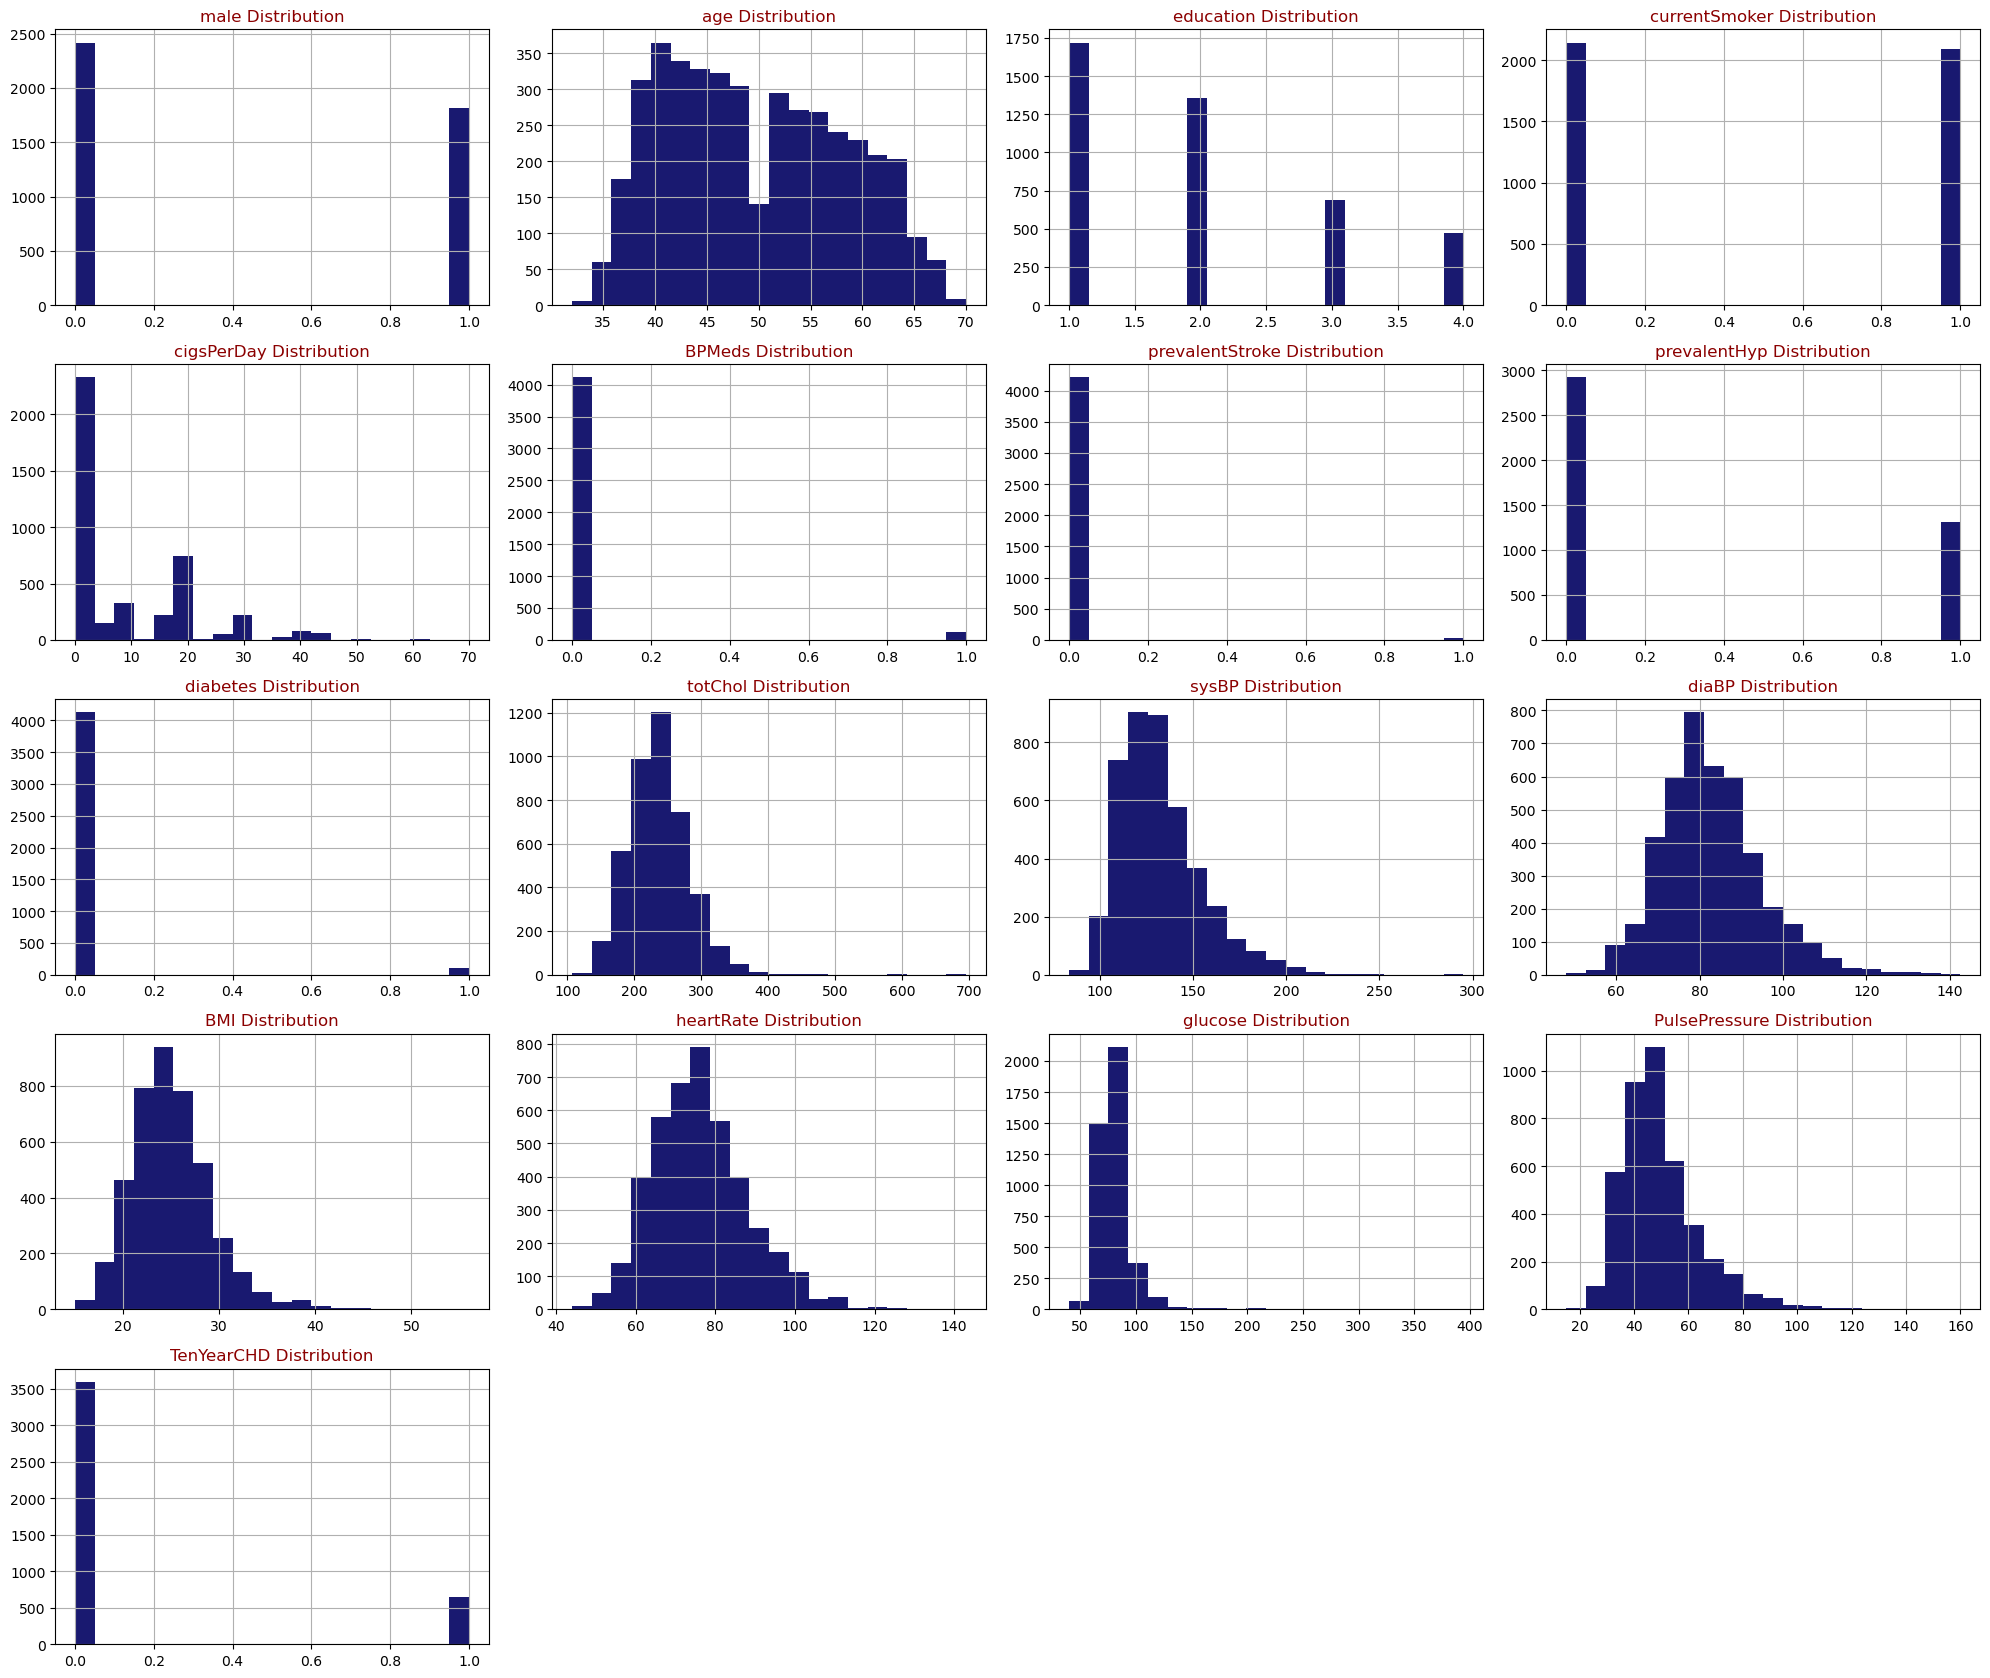

In [17]:
# distributions for each variable
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='midnightblue')
        ax.set_title(feature+" Distribution",color='DarkRed')        
    fig.tight_layout()  
    plt.show()
    
draw_histograms(df_pd,df_pd.columns,6,4)

In [18]:
###### measuring variable importance to TenYearCHD
from sklearn.feature_selection import SelectKBest, f_classif, chi2
X = df_pd.iloc[:,0:16]
y = df_pd.iloc[:,-1]  

bestfeatures = SelectKBest(score_func=chi2)
best_fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(best_fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  
featureScores.sort_values('Score', ascending=False)

,Features,Score
15,PulsePressure,791.204669
10,sysBP,728.292522
14,glucose,392.870029
1,age,318.597444
9,totChol,234.228268
4,cigsPerDay,221.680719
11,diaBP,153.090954
7,prevalentHyp,92.167857
8,diabetes,39.103710
5,BPMeds,30.723031


# Modeling

### Benchmark Model: Logistic Regression (All Features)

In [19]:
#define columns to keep/drop for baseline
dont_want_bench = ["TenYearCHD"]
vars_keep_bench = [x for x in df.columns if x not in dont_want_bench]
train_test = [0.8, 0.2]

train_data, test_data = df.randomSplit(train_test, seed=314)
models_used1 = ["Log Reg"]
metrics_cv_base= pd.DataFrame(index= models_used1, columns=['Accuracy','auroc', 'Precision', 'F1', 'Recall', 'Run Time'])

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline  
from pyspark.ml.feature import * 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

#logreg baseline model with top 3 variables
#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep_bench], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
lr = LogisticRegression(labelCol='TenYearCHD')

#pipeline
pipe1 = Pipeline(stages=[va,standardScaler,lr])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")
#time 
import time
t0 = time.time()

# Fit the pipeline
model_bench = pipe1.fit(train_data)

# Make predictions
predictions_bench = model_bench.transform(test_data)

#prepare to convert to RDD
predict_RDD_bench = predictions_bench.select(['TenYearCHD', 'prediction'])

#extract auroc from binary
auroc_bench = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_bench)

#multiclass evaluator 
evaluatorm1 = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_bench = evaluatorm1.setMetricName("weightedPrecision").evaluate(predict_RDD_bench)
accuracy_bench = evaluatorm1.setMetricName("accuracy").evaluate(predict_RDD_bench)
f1_bench = evaluatorm1.setMetricName("f1").evaluate(predict_RDD_bench)
recall_bench = evaluatorm1.setMetricName("recallByLabel").evaluate(predict_RDD_bench)

#add to metrics df
metrics_cv_base['auroc'].loc["Log Reg"] =  auroc_bench
metrics_cv_base['Accuracy'].loc["Log Reg"] = accuracy_bench * 100
metrics_cv_base['Precision'].loc["Log Reg"] = precision_bench
metrics_cv_base['F1'].loc["Log Reg"] = f1_bench 
metrics_cv_base['Recall'].loc["Log Reg"] = recall_bench

#confusion matrix
multi_bench = MulticlassMetrics(predict_RDD_bench.rdd.map(lambda line: (line[1], line[0])))
print(multi_bench.confusionMatrix().toArray())

#time
time_bench = time.time() - t0
metrics_cv_base['Run Time'].loc["Log Reg"] = time_bench 


print("Accuracy : " + str(accuracy_bench*100) + "%")
print("train time:", time_bench )

[[747.   3.]
 [104.  12.]]
Accuracy : 87.64434180138568%
train time: 7.463578939437866


### Benchmark Results

In [21]:
metrics_cv_base

,Accuracy,auroc,Precision,F1,Recall,Run Time
Log Reg,87.6443,0.549724,0.867371,0.83271,0.996,7.46358


## All Features

In [22]:
vars_keep = [x for x in df.columns if x != "TenYearCHD"]

In [23]:
models_used = ["Log Reg","Random Forest", "Decision Tree", "Gradient Boosted"]
metrics_cv = pd.DataFrame(index= models_used,columns=['Accuracy','auroc', 'Precision', 'F1', 'Recall', 'Run Time'])

### Logistic Regression

In [24]:
#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
lr = LogisticRegression(labelCol='TenYearCHD')

#pipeline
pipe1 = Pipeline(stages=[va,standardScaler,lr])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0001,0.001, 0.01, 0.1, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [1, 5, 10, 15]) \
    .build()

#time 
import time
t0 = time.time()

#cv
cv_lr = CrossValidator(estimator=pipe1,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)
# Fit the pipeline
model_lr = cv_lr.setParallelism(4).fit(train_data)

#bestmod
bestmod_lr = model_lr.bestModel

# Make predictions
predictions_lr = bestmod_lr.transform(test_data)

#prepare to convert to RDD
predict_RDD_lr = predictions_lr.select(['TenYearCHD', 'prediction'])

#extract auroc from binary
auroc_lr = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_lr)

#multiclass evaluator 
evaluatorm = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metri s
precision_lr = evaluatorm.setMetricName("weightedPrecision").evaluate(predict_RDD_lr)
accuracy_lr = evaluatorm.setMetricName("accuracy").evaluate(predict_RDD_lr)
f1_lr = evaluatorm.setMetricName("f1").evaluate(predict_RDD_lr)
recall_lr = evaluatorm.setMetricName("recallByLabel").evaluate(predict_RDD_lr)

#add to metrics df
metrics_cv['auroc'].loc["Log Reg"] =  auroc_lr 
metrics_cv['Accuracy'].loc["Log Reg"] = accuracy_lr * 100
metrics_cv['Precision'].loc["Log Reg"] = precision_lr 
metrics_cv['F1'].loc["Log Reg"] = f1_lr 
metrics_cv['Recall'].loc["Log Reg"] = recall_lr 

#time
time_lr = time.time() - t0
metrics_cv['Run Time'].loc["Log Reg"] = time_lr 

#confusion matrix
multi_lr = MulticlassMetrics(predict_RDD_lr.rdd.map(lambda line: (line[1], line[0])))
print(multi_lr.confusionMatrix().toArray())

print("Accuracy : " + str(accuracy_lr*100) + "%")

[[745.   5.]
 [109.   7.]]
Accuracy : 86.83602771362587%


##### Best Model Parameters

In [25]:
print('Best Param - RegParam: ', bestmod_lr.stages[-1]._java_obj.getRegParam())
print('Best Param - MaxIter: ', bestmod_lr.stages[-1]._java_obj.getMaxIter())

Best Param - RegParam:  0.0001
Best Param - MaxIter:  5


### Random Forest

In [26]:
from pyspark.ml.classification import RandomForestClassifier

#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
rf = RandomForestClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe2 = Pipeline(stages=[va, standardScaler,rf])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5,10,15,20])  \
    .build()

#time 
import time
t0 = time.time()

#cv
cv_rf = CrossValidator(estimator=pipe2,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_rf = cv_rf.setParallelism(4).fit(train_data)

#bestmod
bestmod_rf = model_rf.bestModel

# Make predictions
predictions_rf = bestmod_rf.transform(test_data)

#prepare to convert to RDD
predict_RDD_rf = predictions_rf.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_rf = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_rf)

#multiclass evaluator 
evaluatorm = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_rf = evaluatorm.setMetricName("weightedPrecision").evaluate(predict_RDD_rf)
accuracy_rf = evaluatorm.setMetricName("accuracy").evaluate(predict_RDD_rf)
f1_rf = evaluatorm.setMetricName("f1").evaluate(predict_RDD_rf)
recall_rf = evaluatorm.setMetricName("recallByLabel").evaluate(predict_RDD_rf)

#add to metrics df
metrics_cv['auroc'].loc["Random Forest"] = auroc_rf
metrics_cv['Accuracy'].loc["Random Forest"] = accuracy_rf*100
metrics_cv['Precision'].loc["Random Forest"] = precision_rf
metrics_cv['F1'].loc["Random Forest"] = f1_rf
metrics_cv['Recall'].loc["Random Forest"] = recall_rf

#time
time_rf = time.time() - t0
metrics_cv['Run Time'].loc["Random Forest"] = time_rf 

#confusion matrix
multi_rf = MulticlassMetrics(predict_RDD_rf.rdd.map(lambda line: (line[1], line[0])))
print(multi_rf.confusionMatrix().toArray())

print("Accuracy : " + str(accuracy_rf*100) + "%")

[[749.   1.]
 [115.   1.]]
Accuracy : 86.60508083140877%


#### Best Model Parameters

In [27]:
print('Best Param - Num Trees: ', bestmod_rf.stages[-1]._java_obj.getNumTrees())

Best Param - Num Trees:  10


### Decision Tree

In [28]:
from pyspark.ml.classification import DecisionTreeClassifier
#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
dt = DecisionTreeClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe3 = Pipeline(stages=[va, standardScaler,dt])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [2, 5, 10, 20, 30])\
             .build()

#time 
import time
t0 = time.time()

#cv
cv_dt = CrossValidator(estimator=pipe2,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_dt = cv_dt.setParallelism(4).fit(train_data)

#bestmod
bestmod_dt = model_dt.bestModel

# Make predictions
predictions_dt = bestmod_dt.transform(test_data)

#prepare to convert to RDD
predict_RDD_dt = predictions_dt.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_dt = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_dt)

#multiclass evaluator 
evaluatorm = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_dt = evaluatorm.setMetricName("weightedPrecision").evaluate(predict_RDD_dt)
accuracy_dt = evaluatorm.setMetricName("accuracy").evaluate(predict_RDD_dt)
f1_dt = evaluatorm.setMetricName("f1").evaluate(predict_RDD_dt)
recall_dt = evaluatorm.setMetricName("recallByLabel").evaluate(predict_RDD_dt)

#add to metrics df
metrics_cv['auroc'].loc["Decision Tree"] = auroc_dt
metrics_cv['Accuracy'].loc["Decision Tree"] = accuracy_dt*100
metrics_cv['Precision'].loc["Decision Tree"] = precision_dt
metrics_cv['F1'].loc["Decision Tree"] = f1_dt
metrics_cv['Recall'].loc["Decision Tree"] = recall_dt


#time
time_dt = time.time() - t0
metrics_cv['Run Time'].loc["Decision Tree"] = time_dt


#confusion matrix
multi_dt = MulticlassMetrics(predict_RDD_dt.rdd.map(lambda line: (line[1], line[0])))
print(multi_dt.confusionMatrix().toArray())

print("Accuracy : " + str(accuracy_dt*100) + "%")

[[750.   0.]
 [116.   0.]]
Accuracy : 86.60508083140877%


#### Best Model Parameters

In [29]:
print('Best Param - MaxDepth: ', bestmod_dt.stages[-1]._java_obj.getMaxDepth())

Best Param - MaxDepth:  5


### Gradient Boost Tree

In [30]:
from pyspark.ml.classification import GBTClassifier

#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
gb = GBTClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe4 = Pipeline(stages=[va,standardScaler,gb])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder().addGrid(gb.maxDepth, [2, 5, 10])\
             .addGrid(gb.maxBins, [10,15,20])\
             .addGrid(gb.maxIter, [1,5,10,15])\
             .build()

#time 
import time
t0 = time.time()

#cv
cv_gb = CrossValidator(estimator=pipe4,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_gb = cv_gb.setParallelism(8).fit(train_data)

#bestmod
bestmod_gb = model_gb.bestModel

# Make predictions
predictions_gb = bestmod_gb.transform(test_data)

#prepare to convert to RDD
predict_RDD_gb = predictions_gb.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_gb = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_gb)

#multiclass evaluator 
evaluatorm = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_gb = evaluatorm.setMetricName("weightedPrecision").evaluate(predict_RDD_gb)
accuracy_gb = evaluatorm.setMetricName("accuracy").evaluate(predict_RDD_gb)
f1_gb = evaluatorm.setMetricName("f1").evaluate(predict_RDD_gb)
recall_gb = evaluatorm.setMetricName("recallByLabel").evaluate(predict_RDD_gb)

#add to metrics df
metrics_cv['auroc'].loc["Gradient Boosted"] = auroc_gb
metrics_cv['Accuracy'].loc["Gradient Boosted"] = accuracy_gb*100
metrics_cv['Precision'].loc["Gradient Boosted"] = precision_gb
metrics_cv['F1'].loc["Gradient Boosted"] = f1_gb
metrics_cv['Recall'].loc["Gradient Boosted"] = recall_gb

#time
time_gb = time.time() - t0
metrics_cv['Run Time'].loc["Gradient Boosted"] = time_gb

#confusion matrix
multi_gb = MulticlassMetrics(predict_RDD_gb.rdd.map(lambda line: (line[1], line[0])))
print(multi_gb.confusionMatrix().toArray())

print("Accuracy : " + str(accuracy_gb*100) + "%")

[[669.  81.]
 [ 94.  22.]]
Accuracy : 79.79214780600462%


#### Best Model Parameters

In [31]:
print('Best Param - MaxDepth: ', bestmod_gb.stages[-1]._java_obj.getMaxDepth())
print('Best Param - MaxBins: ', bestmod_gb.stages[-1]._java_obj.getMaxBins())
print('Best Param - MaxIter: ', bestmod_gb.stages[-1]._java_obj.getMaxIter())

Best Param - MaxDepth:  10
Best Param - MaxBins:  10
Best Param - MaxIter:  10


### Results using all variables

In [32]:
metrics_cv

,Accuracy,auroc,Precision,F1,Recall,Run Time
Log Reg,86.836,0.526839,0.83365,0.819149,0.993333,38.8987
Random Forest,86.6051,0.503644,0.817752,0.806077,0.998667,10.2891
Decision Tree,86.6051,0.5,0.750044,0.803884,1,14.4648
Gradient Boosted,79.7921,0.540828,0.787966,0.792792,0.892,134.904


## Drop variables: All Features with Importance <100

In [33]:
#define columns to keep
dont_want = ["TenYearCHD", "prevalentHyp", "heartrate", "education", 'diabetes', 'BPMeds', 'male','prevalentStroke',"BMI",'currentSmoker']
vars_keep2 = [x for x in df.columns if x not in dont_want]

models_used = ["Log Reg","Random Forest", "Decision Tree", "Gradient Boosted"]
metrics_cv_drop = pd.DataFrame(index= models_used, columns=['Accuracy','auroc', 'Precision', 'F1', 'Recall', 'Run Time'])

### Logistic Regression with dropped variables (set 1)

In [34]:
#logreg
#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep2], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
lr = LogisticRegression(labelCol='TenYearCHD')

#pipeline
pipe1 = Pipeline(stages=[va,standardScaler,lr])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0001,0.001, 0.01, 0.1, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [1, 5, 10, 15]) \
    .build()

#time 
import time
t0 = time.time()

#cv
cv_lr_drop = CrossValidator(estimator=pipe1,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)
# Fit the pipeline
model_lr_drop = cv_lr_drop.setParallelism(4).fit(train_data)

#bestmod
bestmod_lr_drop = model_lr_drop.bestModel

# Make predictions
predictions_lr_drop = bestmod_lr_drop.transform(test_data)

#prepare to convert to RDD
predict_RDD_lr_drop = predictions_lr_drop.select(['TenYearCHD', 'prediction'])

#extract auroc from binary
auroc_lr_drop = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_lr_drop)

#multiclass evaluator 
evaluatorm = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_lr_drop = evaluatorm.setMetricName("weightedPrecision").evaluate(predict_RDD_lr_drop)
accuracy_lr_drop = evaluatorm.setMetricName("accuracy").evaluate(predict_RDD_lr_drop)
f1_lr_drop = evaluatorm.setMetricName("f1").evaluate(predict_RDD_lr_drop)
recall_lr_drop = evaluatorm.setMetricName("recallByLabel").evaluate(predict_RDD_lr_drop)

#add to metrics df
metrics_cv_drop['auroc'].loc["Log Reg"] =  auroc_lr_drop
metrics_cv_drop['Accuracy'].loc["Log Reg"] = accuracy_lr_drop * 100
metrics_cv_drop['Precision'].loc["Log Reg"] = precision_lr_drop 
metrics_cv_drop['F1'].loc["Log Reg"] = f1_lr_drop 
metrics_cv_drop['Recall'].loc["Log Reg"] = recall_lr_drop

#time
time_lr_drop = time.time() - t0
metrics_cv_drop['Run Time'].loc["Log Reg"] = time_lr_drop

#confusion matrix
multi_lr_drop = MulticlassMetrics(predict_RDD_lr_drop.rdd.map(lambda line: (line[1], line[0])))
print(multi_lr_drop.confusionMatrix().toArray())

print("Accuracy : " + str(accuracy_lr_drop*100) + "%")

[[749.   1.]
 [115.   1.]]
Accuracy : 86.60508083140877%


##### Best Model Parameters 

In [35]:
print('Best Param - RegParam: ', bestmod_lr_drop.stages[-1]._java_obj.getRegParam())
print('Best Param - MaxIter: ', bestmod_lr_drop.stages[-1]._java_obj.getMaxIter())

Best Param - RegParam:  0.0001
Best Param - MaxIter:  15


### Random Forest with dropped variables (set 1)

In [36]:
#random forest
from pyspark.ml.classification import RandomForestClassifier

#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep2], outputCol="features")


# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)


#model
rf = RandomForestClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe2 = Pipeline(stages=[va, standardScaler,rf])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5,10,15,20])  \
    .build()

#time 
import time
t0 = time.time()

#cv
cv_rf_drop = CrossValidator(estimator=pipe2,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_rf_drop = cv_rf_drop.setParallelism(4).fit(train_data)

#bestmod
bestmod_rf_drop = model_rf_drop.bestModel

# Make predictions
predictions_rf_drop = bestmod_rf_drop.transform(test_data)

#prepare to convert to RDD
predict_RDD_rf_drop = predictions_rf_drop.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_rf_drop = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_rf_drop)

#multiclass evaluator 
evaluatorm = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_rf_drop = evaluatorm.setMetricName("weightedPrecision").evaluate(predict_RDD_rf_drop)
accuracy_rf_drop = evaluatorm.setMetricName("accuracy").evaluate(predict_RDD_rf_drop)
f1_rf_drop = evaluatorm.setMetricName("f1").evaluate(predict_RDD_rf_drop)
recall_rf_drop = evaluatorm.setMetricName("recallByLabel").evaluate(predict_RDD_rf_drop)

#add metrics to metrics df
metrics_cv_drop['auroc'].loc["Random Forest"] = auroc_rf_drop
metrics_cv_drop['Accuracy'].loc["Random Forest"] = accuracy_rf_drop*100
metrics_cv_drop['Precision'].loc["Random Forest"] = precision_rf_drop
metrics_cv_drop['F1'].loc["Random Forest"] = f1_rf_drop 
metrics_cv_drop['Recall'].loc["Random Forest"] = recall_rf_drop

#time
time_rf_drop = time.time() - t0
metrics_cv_drop['Run Time'].loc["Random Forest"] = time_rf_drop

#confusion matrix
multi_rf_drop = MulticlassMetrics(predict_RDD_rf_drop.rdd.map(lambda line: (line[1], line[0])))

print(multi_rf_drop.confusionMatrix().toArray())

print("Accuracy : " + str(accuracy_rf_drop*100) + "%")

[[745.   5.]
 [112.   4.]]
Accuracy : 86.48960739030022%


#### Best Model Parameters

In [37]:
print('Best Param - Num Trees: ', bestmod_rf_drop.stages[-1]._java_obj.getNumTrees())

Best Param - Num Trees:  5


### Decision Tree with dropped variables (set 1)

In [38]:
# decision tree
#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep2], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
dt = DecisionTreeClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe3 = Pipeline(stages=[va, standardScaler,dt])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [2, 5, 10, 20, 30])\
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])\
             .build()

#time 
import time
t0 = time.time()

#cv
cv_dt_drop = CrossValidator(estimator=pipe3,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_dt_drop = cv_dt_drop.setParallelism(4).fit(train_data)

#bestmod
bestmod_dt_drop = model_dt_drop.bestModel


# Make predictions
predictions_dt_drop = bestmod_dt_drop.transform(test_data)

#prepare to convert to RDD
predict_RDD_dt_drop = predictions_dt_drop.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_dt_drop = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_dt_drop)

#multiclass evaluator 
evaluatorm = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_dt_drop = evaluatorm.setMetricName("weightedPrecision").evaluate(predict_RDD_dt_drop)
accuracy_dt_drop = evaluatorm.setMetricName("accuracy").evaluate(predict_RDD_dt_drop)
f1_dt_drop = evaluatorm.setMetricName("f1").evaluate(predict_RDD_dt_drop)
recall_dt_drop = evaluatorm.setMetricName("recallByLabel").evaluate(predict_RDD_dt_drop)

#add metrics to metrics df
metrics_cv_drop['auroc'].loc["Decision Tree"] = auroc_dt_drop
metrics_cv_drop['Accuracy'].loc["Decision Tree"] = accuracy_dt_drop*100
metrics_cv_drop['Precision'].loc["Decision Tree"] = precision_dt_drop
metrics_cv_drop['F1'].loc["Decision Tree"] = f1_dt_drop 
metrics_cv_drop['Recall'].loc["Decision Tree"] = recall_dt_drop

#time
time_dt_drop = time.time() - t0
metrics_cv_drop['Run Time'].loc["Decision Tree"] = time_dt_drop

#confusion matrix
multi_dt_drop = MulticlassMetrics(predict_RDD_dt_drop.rdd.map(lambda line: (line[1], line[0])))

print(multi_dt_drop.confusionMatrix().toArray())


print("Accuracy : " + str(accuracy_dt_drop*100) + "%")

[[638. 112.]
 [ 87.  29.]]
Accuracy : 77.02078521939953%


#### Best Model Parameters

In [39]:
print('Best Param - MaxDepth: ', bestmod_dt_drop.stages[-1]._java_obj.getMaxDepth())

Best Param - MaxDepth:  20


### Gradient Boost with dropped variables (set 1)

### 

In [40]:
#gradient boost
from pyspark.ml.classification import GBTClassifier

#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep2], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
gb = GBTClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe4 = Pipeline(stages=[va,standardScaler,gb])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder().addGrid(gb.maxDepth, [2, 5, 10])\
             .addGrid(gb.maxBins, [10, 20])\
             .addGrid(gb.maxIter, [1,5,10,15])\
             .build()

#time 
import time
t0 = time.time()

#cv
cv_gb_drop = CrossValidator(estimator=pipe4,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_gb_drop = cv_gb_drop.setParallelism(4).fit(train_data)

#bestmod
bestmod_gb_drop = model_gb_drop.bestModel


# Make predictions
predictions_gb_drop = bestmod_gb_drop.transform(test_data)


#prepare to convert to RDD
predict_RDD_gb_drop = predictions_gb_drop.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_gb_drop = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_gb_drop)

#multiclass evaluator 
evaluatorm = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_gb_drop = evaluatorm.setMetricName("weightedPrecision").evaluate(predict_RDD_gb_drop)
accuracy_gb_drop = evaluatorm.setMetricName("accuracy").evaluate(predict_RDD_gb_drop)
f1_gb_drop = evaluatorm.setMetricName("f1").evaluate(predict_RDD_gb_drop)
recall_gb_drop = evaluatorm.setMetricName("recallByLabel").evaluate(predict_RDD_gb_drop)


metrics_cv_drop['auroc'].loc["Gradient Boosted"] = auroc_gb_drop
metrics_cv_drop['Accuracy'].loc["Gradient Boosted"] = accuracy_gb_drop*100
metrics_cv_drop['Precision'].loc["Gradient Boosted"] = precision_gb_drop
metrics_cv_drop['F1'].loc["Gradient Boosted"] = f1_gb_drop 
metrics_cv_drop['Recall'].loc["Gradient Boosted"] = recall_gb_drop


#time
time_gb_drop = time.time() - t0
metrics_cv_drop['Run Time'].loc["Gradient Boosted"] = time_gb_drop

#confusion matrix
multi_gb_drop = MulticlassMetrics(predict_RDD_gb_drop.rdd.map(lambda line: (line[1], line[0])))

print(multi_gb_drop.confusionMatrix().toArray())


print("Accuracy : " + str(accuracy_gb_drop*100) + "%")

[[678.  72.]
 [ 83.  33.]]
Accuracy : 82.10161662817552%


In [41]:
print('Best Param - MaxDepth: ', bestmod_gb_drop.stages[-1]._java_obj.getMaxDepth())
print('Best Param - MaxBins: ', bestmod_gb_drop.stages[-1]._java_obj.getMaxBins())
print('Best Param - MaxIter: ', bestmod_gb_drop.stages[-1]._java_obj.getMaxIter())

Best Param - MaxDepth:  10
Best Param - MaxBins:  20
Best Param - MaxIter:  5


### Results with dropped variables (set 1)

In [42]:
metrics_cv_drop

,Accuracy,auroc,Precision,F1,Recall,Run Time
Log Reg,86.6051,0.503644,0.817752,0.806077,0.998667,32.9892
Random Forest,86.4896,0.513908,0.812401,0.811569,0.993333,8.95139
Decision Tree,77.0208,0.550333,0.789675,0.779437,0.850667,44.6713
Gradient Boosted,82.1016,0.594241,0.813692,0.817213,0.904,118.625


## Drop variables: current smoker, heart rate, education, BMI, prevalent smoke (set 2)

In [43]:
#define columns to keep/drop 
dont_want2 = ["TenYearCHD", "currentSmoker", "heartRate", "education", "BMI","prevalentStroke"]
vars_keep4 = [x for x in df.columns if x not in dont_want2]

models_used2 = ["Log Reg","Random Forest", "Decision Tree", "Gradient Boosted"]
metrics_cv_drop2 = pd.DataFrame(index= models_used2, columns=['Accuracy','auroc', 'Precision', 'F1', 'Recall','Run Time'])

### Logistic Regression with dropped variables (set 2)

In [44]:
#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep4], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
lr = LogisticRegression(labelCol='TenYearCHD')

#pipeline
pipe1 = Pipeline(stages=[va,standardScaler,lr])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0001,0.001, 0.01, 0.1, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [1, 5, 10, 15]) \
    .build()

#time 
import time
t0 = time.time()

#cv
cv_lr_drop2 = CrossValidator(estimator=pipe1,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)
# Fit the pipeline
model_lr_drop2 = cv_lr_drop2.setParallelism(4).fit(train_data)

#bestmod
bestmod_lr_drop2 = model_lr_drop2.bestModel

# Make predictions
predictions_lr_drop2 = bestmod_lr_drop2.transform(test_data)

#prepare to convert to RDD
predict_RDD_lr_drop2 = predictions_lr_drop2.select(['TenYearCHD', 'prediction'])

#extract auroc from binary
auroc_lr_drop2 = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_lr_drop2)

#multiclass evaluator 
evaluatorm2 = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_lr_drop2 = evaluatorm2.setMetricName("weightedPrecision").evaluate(predict_RDD_lr_drop2)
accuracy_lr_drop2 = evaluatorm2.setMetricName("accuracy").evaluate(predict_RDD_lr_drop2)
f1_lr_drop2 = evaluatorm2.setMetricName("f1").evaluate(predict_RDD_lr_drop2)
recall_lr_drop2 = evaluatorm2.setMetricName("recallByLabel").evaluate(predict_RDD_lr_drop2)

#add to metrics df
metrics_cv_drop2['auroc'].loc["Log Reg"] =  auroc_lr_drop2
metrics_cv_drop2['Accuracy'].loc["Log Reg"] = accuracy_lr_drop2 * 100
metrics_cv_drop2['Precision'].loc["Log Reg"] = precision_lr_drop2 
metrics_cv_drop2['F1'].loc["Log Reg"] = f1_lr_drop2 
metrics_cv_drop2['Recall'].loc["Log Reg"] = recall_lr_drop2

#time
time_lr_drop1 = time.time() - t0
metrics_cv_drop2['Run Time'].loc["Log Reg"] = time_lr_drop1
#confusion matrix
multi_lr_drop2 = MulticlassMetrics(predict_RDD_lr_drop2.rdd.map(lambda line: (line[1], line[0])))
print(multi_lr_drop2.confusionMatrix().toArray())

print("Accuracy : " + str(accuracy_lr_drop2*100) + "%")

[[745.   5.]
 [113.   3.]]
Accuracy : 86.37413394919169%


#### Best Model Parameters

In [45]:
print('Best Param - RegParam: ', bestmod_lr_drop2.stages[-1]._java_obj.getRegParam())
print('Best Param - MaxIter: ', bestmod_lr_drop2.stages[-1]._java_obj.getMaxIter())

Best Param - RegParam:  0.0001
Best Param - MaxIter:  10


### Random Forest with dropped variables (set 2)

In [46]:
#random forest
from pyspark.ml.classification import RandomForestClassifier

#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep4], outputCol="features")


# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)


#model
rf = RandomForestClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe2 = Pipeline(stages=[va, standardScaler,rf])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5,10,15,20])  \
    .build()

#time 
import time
t0 = time.time()

#cv
cv_rf_drop1 = CrossValidator(estimator=pipe2,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_rf_drop1 = cv_rf_drop1.setParallelism(4).fit(train_data)

#bestmod
bestmod_rf_drop1 = model_rf_drop1.bestModel

# Make predictions
predictions_rf_drop1 = bestmod_rf_drop1.transform(test_data)

#prepare to convert to RDD
predict_RDD_rf_drop1 = predictions_rf_drop1.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_rf_drop1 = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_rf_drop1)

#multiclass evaluator 
evaluatorm3 = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_rf_drop1 = evaluatorm3.setMetricName("weightedPrecision").evaluate(predict_RDD_rf_drop1)
accuracy_rf_drop1 = evaluatorm3.setMetricName("accuracy").evaluate(predict_RDD_rf_drop1)
f1_rf_drop1 = evaluatorm3.setMetricName("f1").evaluate(predict_RDD_rf_drop1)
recall_rf_drop1 = evaluatorm3.setMetricName("recallByLabel").evaluate(predict_RDD_rf_drop1)

#add metrics to metrics df
metrics_cv_drop2['auroc'].loc["Random Forest"] = auroc_rf_drop1
metrics_cv_drop2['Accuracy'].loc["Random Forest"] = accuracy_rf_drop1*100
metrics_cv_drop2['Precision'].loc["Random Forest"] = precision_rf_drop1
metrics_cv_drop2['F1'].loc["Random Forest"] = f1_rf_drop1
metrics_cv_drop2['Recall'].loc["Random Forest"] = recall_rf_drop1

#time
time_rf_drop1 = time.time() - t0
metrics_cv_drop2['Run Time'].loc["Random Forest"] = time_rf_drop1

#confusion matrix
multi_rf_drop1 = MulticlassMetrics(predict_RDD_rf_drop1.rdd.map(lambda line: (line[1], line[0])))

print(multi_rf_drop1.confusionMatrix().toArray())

print("Accuracy : " + str(accuracy_rf_drop1*100) + "%")

[[748.   2.]
 [113.   3.]]
Accuracy : 86.72055427251732%


#### Best Model Parameters

In [47]:
print('Best Param - Num Trees: ', bestmod_rf_drop1.stages[-1]._java_obj.getNumTrees())

Best Param - Num Trees:  15


### Decision Tree with dropped variables (set 2)

In [48]:
# decision tree
#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep4], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
dt = DecisionTreeClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe3 = Pipeline(stages=[va, standardScaler,dt])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [2, 5, 10, 20, 30])\
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])\
             .build()

#time 
import time
t0 = time.time()

#cv
cv_dt_drop1 = CrossValidator(estimator=pipe3,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_dt_drop1 = cv_dt_drop1.setParallelism(4).fit(train_data)

#bestmod
bestmod_dt_drop1 = model_dt_drop1.bestModel


# Make predictions
predictions_dt_drop1 = bestmod_dt_drop1.transform(test_data)

#prepare to convert to RDD
predict_RDD_dt_drop1 = predictions_dt_drop1.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_dt_drop1 = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_dt_drop1)

#multiclass evaluator 
evaluatorm3 = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_dt_drop1 = evaluatorm3.setMetricName("weightedPrecision").evaluate(predict_RDD_dt_drop1)
accuracy_dt_drop1 = evaluatorm3.setMetricName("accuracy").evaluate(predict_RDD_dt_drop1)
f1_dt_drop1 = evaluatorm3.setMetricName("f1").evaluate(predict_RDD_dt_drop1)
recall_dt_drop1 = evaluatorm3.setMetricName("recallByLabel").evaluate(predict_RDD_dt_drop1)

#add metrics to metrics df
metrics_cv_drop2['auroc'].loc["Decision Tree"] = auroc_dt_drop1
metrics_cv_drop2['Accuracy'].loc["Decision Tree"] = accuracy_dt_drop1*100
metrics_cv_drop2['Precision'].loc["Decision Tree"] = precision_dt_drop1
metrics_cv_drop2['F1'].loc["Decision Tree"] = f1_dt_drop1
metrics_cv_drop2['Recall'].loc["Decision Tree"] = recall_dt_drop1

#time
time_dt_drop1 = time.time() - t0
metrics_cv_drop2['Run Time'].loc["Decision Tree"] = time_dt_drop1

#confusion matrix
multi_dt_drop1 = MulticlassMetrics(predict_RDD_dt_drop1.rdd.map(lambda line: (line[1], line[0])))

print(multi_dt_drop1.confusionMatrix().toArray())


print("Accuracy : " + str(accuracy_dt_drop1*100) + "%")

[[622. 128.]
 [ 83.  33.]]
Accuracy : 75.635103926097%


#### Best Model Parameters

In [49]:
print('Best Param - MaxDepth: ', bestmod_dt_drop1.stages[-1]._java_obj.getMaxDepth())

Best Param - MaxDepth:  30


### Gradient Boost with dropped variables (set 2)

In [50]:
#gradient boost
from pyspark.ml.classification import GBTClassifier

#vector assembler
va = VectorAssembler(inputCols=[x for x in df.columns if x in vars_keep4], outputCol="features")

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=False)

#model
gb = GBTClassifier(labelCol='TenYearCHD')

#pipeline stages
pipe4 = Pipeline(stages=[va,standardScaler,gb])

# establish evaluator to use with cv
evalbinary = BinaryClassificationEvaluator().setRawPredictionCol("prediction")\
                        .setLabelCol("TenYearCHD").setMetricName("areaUnderROC")

#create paramGrid
paramGrid = ParamGridBuilder().addGrid(gb.maxDepth, [2, 5, 10])\
             .addGrid(gb.maxBins, [10, 20])\
             .addGrid(gb.maxIter, [1,5,10,15])\
             .build()

#time 
import time
t0 = time.time()

#cv
cv_gb_drop1 = CrossValidator(estimator=pipe4,
                          estimatorParamMaps=paramGrid,
                          evaluator=evalbinary,
                          numFolds=5,
                          seed = 314)

# Fit the pipeline
model_gb_drop1 = cv_gb_drop1.setParallelism(4).fit(train_data)

#bestmod
bestmod_gb_drop1 = model_gb_drop1.bestModel

# Make predictions
predictions_gb_drop1 = bestmod_gb_drop1.transform(test_data)

#prepare to convert to RDD
predict_RDD_gb_drop1 = predictions_gb_drop1.select(['TenYearCHD', 'prediction'])

#extract auroc
auroc_gb_drop1 = evalbinary.setMetricName("areaUnderROC").evaluate(predict_RDD_gb_drop1)

#multiclass evaluator 
evaluatorm4 = MulticlassClassificationEvaluator(
    labelCol="TenYearCHD", predictionCol="prediction")

#multiclass metrics
precision_gb_drop1 = evaluatorm4.setMetricName("weightedPrecision").evaluate(predict_RDD_gb_drop1)
accuracy_gb_drop1 = evaluatorm4.setMetricName("accuracy").evaluate(predict_RDD_gb_drop1)
f1_gb_drop1 = evaluatorm4.setMetricName("f1").evaluate(predict_RDD_gb_drop1)
recall_gb_drop1 = evaluatorm4.setMetricName("recallByLabel").evaluate(predict_RDD_gb_drop1)


metrics_cv_drop2['auroc'].loc["Gradient Boosted"] = auroc_gb_drop1
metrics_cv_drop2['Accuracy'].loc["Gradient Boosted"] = accuracy_gb_drop1*100
metrics_cv_drop2['Precision'].loc["Gradient Boosted"] = precision_gb_drop1
metrics_cv_drop2['F1'].loc["Gradient Boosted"] = f1_gb_drop1 
metrics_cv_drop2['Recall'].loc["Gradient Boosted"] = recall_gb_drop1

#time
time_gb_drop1 = time.time() - t0
metrics_cv_drop2['Run Time'].loc["Gradient Boosted"] = time_gb_drop1

#confusion matrix
multi_gb_drop1 = MulticlassMetrics(predict_RDD_gb_drop1.rdd.map(lambda line: (line[1], line[0])))

print(multi_gb_drop1.confusionMatrix().toArray())


print("Accuracy : " + str(accuracy_gb_drop1*100) + "%")

[[680.  70.]
 [ 86.  30.]]
Accuracy : 81.98614318706697%


#### Best Model Parameters

In [51]:
print('Best Param - MaxDepth: ', bestmod_gb_drop1.stages[-1]._java_obj.getMaxDepth())
print('Best Param - MaxBins: ', bestmod_gb_drop1.stages[-1]._java_obj.getMaxBins())
print('Best Param - MaxIter: ', bestmod_gb_drop1.stages[-1]._java_obj.getMaxIter())

Best Param - MaxDepth:  10
Best Param - MaxBins:  10
Best Param - MaxIter:  15


### Results for dropped variables (set 2)

In [52]:
metrics_cv_drop2

,Accuracy,auroc,Precision,F1,Recall,Run Time
Log Reg,86.3741,0.509598,0.802221,0.808979,0.993333,35.3152
Random Forest,86.7206,0.511598,0.832757,0.810871,0.997333,9.24619
Decision Tree,75.6351,0.556908,0.791546,0.772374,0.829333,45.1498
Gradient Boosted,81.9861,0.582644,0.809003,0.81414,0.906667,123.874


### Comparing all results 

Benchmark: 

In [53]:
metrics_cv_base

,Accuracy,auroc,Precision,F1,Recall,Run Time
Log Reg,87.6443,0.549724,0.867371,0.83271,0.996,7.46358


All variables: 

In [54]:
metrics_cv

,Accuracy,auroc,Precision,F1,Recall,Run Time
Log Reg,86.836,0.526839,0.83365,0.819149,0.993333,38.8987
Random Forest,86.6051,0.503644,0.817752,0.806077,0.998667,10.2891
Decision Tree,86.6051,0.5,0.750044,0.803884,1,14.4648
Gradient Boosted,79.7921,0.540828,0.787966,0.792792,0.892,134.904


Dropped set 1: 

In [55]:
metrics_cv_drop

,Accuracy,auroc,Precision,F1,Recall,Run Time
Log Reg,86.6051,0.503644,0.817752,0.806077,0.998667,32.9892
Random Forest,86.4896,0.513908,0.812401,0.811569,0.993333,8.95139
Decision Tree,77.0208,0.550333,0.789675,0.779437,0.850667,44.6713
Gradient Boosted,82.1016,0.594241,0.813692,0.817213,0.904,118.625


Dropped set 2:

In [56]:
metrics_cv_drop2

,Accuracy,auroc,Precision,F1,Recall,Run Time
Log Reg,86.3741,0.509598,0.802221,0.808979,0.993333,35.3152
Random Forest,86.7206,0.511598,0.832757,0.810871,0.997333,9.24619
Decision Tree,75.6351,0.556908,0.791546,0.772374,0.829333,45.1498
Gradient Boosted,81.9861,0.582644,0.809003,0.81414,0.906667,123.874


### Confusions Metrices for Top Models

#### Confusion Matrix for Benchmark

In [60]:
print(multi_bench.confusionMatrix().toArray())

[[747.   3.]
 [104.  12.]]


#### Confusion Matrix for all Features

In [59]:
print(multi_gb.confusionMatrix().toArray())

[[669.  81.]
 [ 94.  22.]]


#### Confusion Matrix for Features with importance > 100

In [58]:
print(multi_gb_drop.confusionMatrix().toArray())

[[678.  72.]
 [ 83.  33.]]


#### Confusions Matrix for all Features except Bottom 5

In [57]:
print(multi_gb_drop1.confusionMatrix().toArray())

[[680.  70.]
 [ 86.  30.]]
